In [1]:
from ohlcv import interval, ohlcv

In [2]:
import pandas as pd
from math import atan

In [3]:
df = ohlcv("EUR/USD",period=interval.fifteenMinute,ticks=1000)

In [4]:
def VWAP(ohlcv):
    df = ohlcv.copy()
    df['cumVol'] = df['vol'].cumsum()
    df['cum_ohc3Vol'] = (((df[['open','high','close']].sum(axis=1))/3)*df['vol']).cumsum()
    df['VWAP'] = df['cum_ohc3Vol']/df['cumVol']
    df.drop(df.columns[[5,6]],axis=1,inplace=True)
    return df

def slope(df,col,n):
    """
    n = bars back
    """
    df = df.copy()
    ser = df[col]
    slp = []
    for i,x in enumerate(ser):
        if i < n:
            slp.append(0)
            continue
        #getting values to find the slope
        b = ser[i]
        a = ser[i-n]
        slope = atan((b-a)/n)
        slp.append(slope)
    df[f'{col}_Slope'] = pd.Series(slp,index=df.index)
    return df

In [5]:
def vwap_slope(ohlcv_data):
    df = ohlcv_data.copy()
    df = VWAP(df)
    df = slope(df,'VWAP',3)
    return df

def o_c(ohlcv,n=33):
    df = ohlcv.copy()
    o = df['open'].rolling(window=n).mean()
    c = df['close'].rolling(window=n).mean()
    df['o_c'] = c-o
    df.dropna(inplace=True)
    return df

In [6]:
df = vwap_slope(df)
df = o_c(df)

In [7]:
df['v_s'] = df['VWAP_Slope'].apply(lambda x: 1 if x>0 else 0)
df['o_s'] = df['o_c'].apply(lambda x: 1 if x>0 else 0)


In [8]:
import numpy as np

In [9]:
df['sell'] = np.where(((df['v_s']==0) & (df['o_s']==0)),-1,0)

In [10]:
df['buy'] = np.where(((df['v_s']==1) & (df['o_s']==1)),1,0)

In [11]:
df['signal'] = np.where(((df.sell==-1)|((df.sell==0)&(df.buy==0))),df.sell,df.buy)

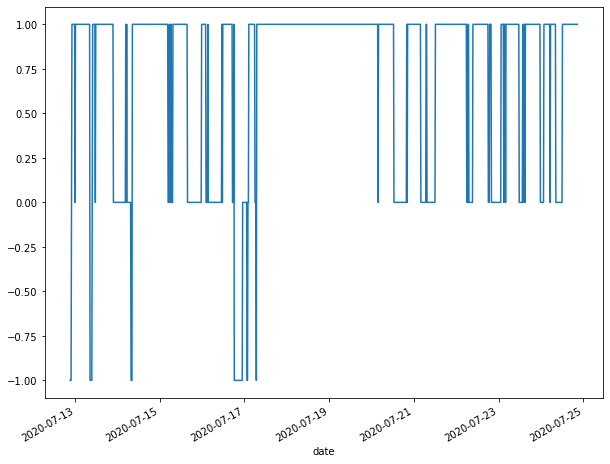

In [12]:
df.signal.plot(figsize=(10,8))